In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [16]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X,y = data['X'], data['labels']

print(X.shape, y.shape)

(300, 2) (300,)


In [17]:
# Define dataset split proportions
val_size = 0.2
test_size = 0.125
is_shuffle = True

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Further split training set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [18]:
# Normalize the feature data
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [19]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define batch size
batch_size = 32

# Create datasets
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [34]:
# class MLP(nn.Module):
#     def __init__(self, input_dims, hidden_dims, output_dims):
#         super(MLP, self).__init__()
#         self.linear1 = nn.Linear(input_dims, hidden_dims)
#         self.relu = nn.ReLU()
#         self.output = nn.Linear(hidden_dims, output_dims)

#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.relu(x)
#         out = self.output(x)
#         return out.squeeze(1)

# class MLP(nn.Module):
#     def __init__(self, input_dims, hidden_dims, output_dims):
#         super(MLP, self).__init__()
#         self.output = nn.Linear(input_dims, output_dims)  # Chỉ một lớp tuyến tính

#     def forward(self, x):
#         out = self.output(x)
#         return out  # CrossEntropyLoss tự động áp dụng Softmax

# class MLP(nn.Module):
#     def __init__(self, input_dims, hidden_dims, output_dims):
#         super(MLP, self).__init__()
#         self.linear1 = nn.Linear(input_dims, hidden_dims)
#         self.linear2 = nn.Linear(hidden_dims, hidden_dims)
#         self.output = nn.Linear(hidden_dims, output_dims)

#     def forward(self, x):
#         x = self.linear1(x)
#         x = torch.sigmoid(x)  # Dùng hàm Sigmoid
#         x = self.linear2(x)
#         x = torch.sigmoid(x)  # Dùng hàm Sigmoid
#         out = self.output(x)
#         return out

# class MLP(nn.Module):
#     def __init__(self, input_dims, hidden_dims, output_dims):
#         super(MLP, self).__init__()
#         self.linear1 = nn.Linear(input_dims, hidden_dims)
#         self.linear2 = nn.Linear(hidden_dims, hidden_dims)
#         self.output = nn.Linear(hidden_dims, output_dims)

#     def forward(self, x):
#         x = self.linear1(x)
#         x = torch.tanh(x)  # Dùng hàm Tanh
#         x = self.linear2(x)
#         x = torch.tanh(x)  # Dùng hàm Tanh
#         out = self.output(x)
#         return out

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        out = self.output(x)
        return out

In [35]:
# Define model dimensions
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 512 # 128

# Instantiate the model and move it to the appropriate device
model = MLP(
    input_dims=input_dims,
    hidden_dims=hidden_dims,
    output_dims=output_dims
).to(device)

In [36]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [37]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [38]:
# Initialize training parameters and metrics
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(epochs):
    # Training phase
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Compute training accuracy
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    # Validation phase
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()

    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Compute validation accuracy
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # Print epoch summary
    print(f"\nEPOCH {epoch + 1}:\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")


EPOCH 1:	Train Loss: 0.857 | Train Acc: 0.529 | Val Loss: 0.953 | Val Acc: 0.500

EPOCH 2:	Train Loss: 0.786 | Train Acc: 0.605 | Val Loss: 0.882 | Val Acc: 0.450

EPOCH 3:	Train Loss: 0.788 | Train Acc: 0.586 | Val Loss: 0.870 | Val Acc: 0.550

EPOCH 4:	Train Loss: 0.744 | Train Acc: 0.576 | Val Loss: 0.835 | Val Acc: 0.600

EPOCH 5:	Train Loss: 0.718 | Train Acc: 0.643 | Val Loss: 0.894 | Val Acc: 0.517

EPOCH 6:	Train Loss: 0.730 | Train Acc: 0.586 | Val Loss: 0.809 | Val Acc: 0.450

EPOCH 7:	Train Loss: 0.724 | Train Acc: 0.548 | Val Loss: 0.784 | Val Acc: 0.433

EPOCH 8:	Train Loss: 0.654 | Train Acc: 0.648 | Val Loss: 0.783 | Val Acc: 0.567

EPOCH 9:	Train Loss: 0.663 | Train Acc: 0.633 | Val Loss: 0.720 | Val Acc: 0.583

EPOCH 10:	Train Loss: 0.623 | Train Acc: 0.657 | Val Loss: 0.702 | Val Acc: 0.667

EPOCH 11:	Train Loss: 0.617 | Train Acc: 0.643 | Val Loss: 0.715 | Val Acc: 0.617

EPOCH 12:	Train Loss: 0.600 | Train Acc: 0.695 | Val Loss: 0.683 | Val Acc: 0.683

EPOCH 13:	Tr

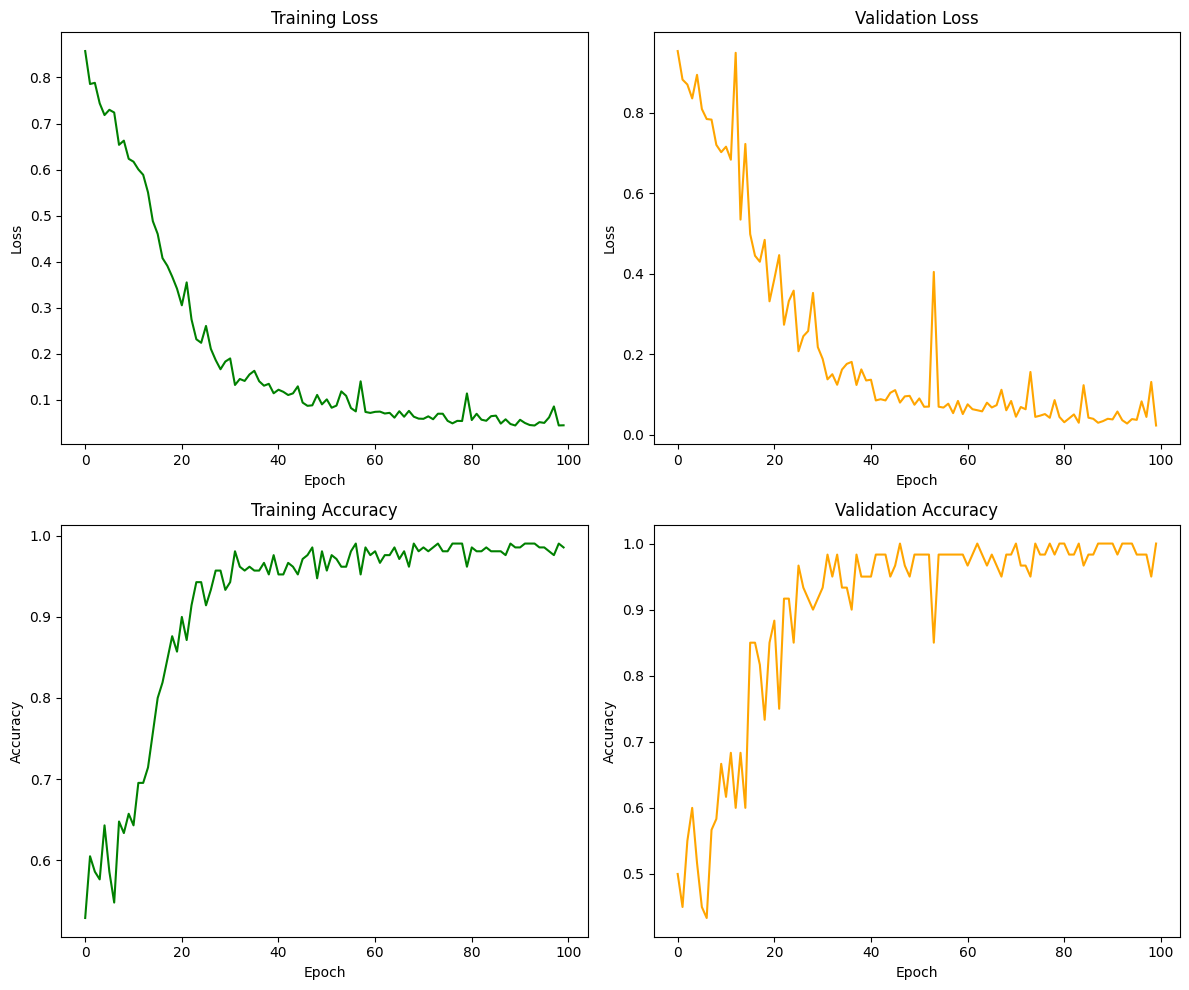

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot training loss
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Plot validation loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Plot training accuracy
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Plot validation accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

# Display the plots
plt.tight_layout()
plt.show()


In [40]:
# Initialize lists to store predictions and targets
test_target = []
test_predict = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        # Move data to the appropriate device
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        # Make predictions
        outputs = model(X_samples)

        # Store predictions and targets
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

# Concatenate all predictions and targets
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Compute test accuracy
test_acc = compute_accuracy(test_predict, test_target)

# Print evaluation results
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.3f}')

Evaluation on test set:
Accuracy: 0.900
